# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Utility-Functions" data-toc-modified-id="Utility-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Utility Functions</a></div><div class="lev1 toc-item"><a href="#Case-Study---Binary-Classification" data-toc-modified-id="Case-Study---Binary-Classification-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Case Study - Binary Classification</a></div><div class="lev2 toc-item"><a href="#Data-Visualization-&amp;-Preprocessing" data-toc-modified-id="Data-Visualization-&amp;-Preprocessing-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data Visualization &amp; Preprocessing</a></div><div class="lev2 toc-item"><a href="#Logistic-Regression-Model" data-toc-modified-id="Logistic-Regression-Model-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Logistic Regression Model</a></div><div class="lev2 toc-item"><a href="#Deep-Model" data-toc-modified-id="Deep-Model-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Deep Model</a></div><div class="lev2 toc-item"><a href="#Deep-Model-Visualization" data-toc-modified-id="Deep-Model-Visualization-24"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Deep Model Visualization</a></div><div class="lev2 toc-item"><a href="#Trial" data-toc-modified-id="Trial-25"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Trial</a></div><div class="lev2 toc-item"><a href="#Even-deeper-model" data-toc-modified-id="Even-deeper-model-26"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Even deeper model</a></div><div class="lev1 toc-item"><a href="#Case-Study---MultiClass-Classification" data-toc-modified-id="Case-Study---MultiClass-Classification-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Case Study - MultiClass Classification</a></div><div class="lev2 toc-item"><a href="#Data-Visualization-&amp;-Preparation" data-toc-modified-id="Data-Visualization-&amp;-Preparation-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data Visualization &amp; Preparation</a></div><div class="lev1 toc-item"><a href="#Case-Study---Regression" data-toc-modified-id="Case-Study---Regression-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Case Study - Regression</a></div><div class="lev2 toc-item"><a href="#Data-Visualization-&amp;-Preparation" data-toc-modified-id="Data-Visualization-&amp;-Preparation-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Data Visualization &amp; Preparation</a></div><div class="lev2 toc-item"><a href="#Linear-Regression-Model" data-toc-modified-id="Linear-Regression-Model-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Linear Regression Model</a></div><div class="lev2 toc-item"><a href="#Deep-Model" data-toc-modified-id="Deep-Model-43"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Deep Model</a></div>

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


# Utility Functions

These are the plotting helper functions used further down in the notebook. You don't need to fully understand what's going on here to get the big picture. The names of the functions are self-explanatory. I would at first recommend to skip this part and proceed to the next Logistic Regression section.

In [86]:
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2==1) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

# Case Study - Binary Classification

We will be using the Human Resources Analytics dataset on Kaggle: https://www.kaggle.com/ludobenistant/hr-analytics

We're trying to predict whether an employee will leave based on various features such as number of projects they worked on, time spent at the company, last performance review, salary etc. The dataset has around 15,000 rows and 9 columns. The column we're trying to predict is called "left". It's a binary column with 0/1 values. The label 1 means that the employee has left.

## Data Visualization & Preprocessing

In [87]:
rawdf = pd.read_csv('../data/titanic.csv')
rawdf.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S
5,6,0,3,"Moran, Mr. James",male,nan,0,0,330877,8.46,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.00,0,0,17463,51.86,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.07,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00,0,2,347742,11.13,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,1,0,237736,30.07,NaN,C


In [88]:
rawdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [134]:
rawdf.describe()
titanic = rawdf.drop(['PassengerId', 'Cabin', 'Name', 'Ticket'], axis=1)

In [135]:
titanic = titanic.dropna(axis=0)#fillna(titanic['Age'].mean())

In [136]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 8 columns):
Survived    712 non-null int64
Pclass      712 non-null int64
Sex         712 non-null object
Age         712 non-null float64
SibSp       712 non-null int64
Parch       712 non-null int64
Fare        712 non-null float64
Embarked    712 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 50.1+ KB


In [137]:
(titanic['Survived'].value_counts())/titanic['Survived'].count()
#(titanic['Pclass'].value_counts())/titanic['Pclass'].count()

0   0.60
1   0.40
Name: Survived, dtype: float64

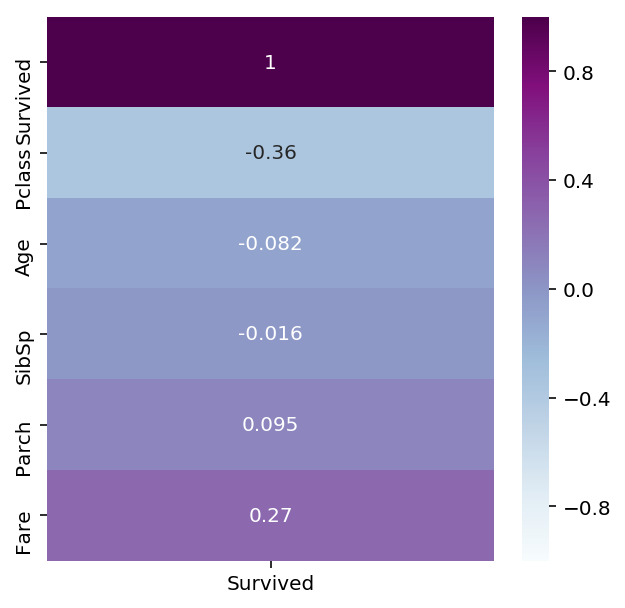

In [138]:
plt.figure(figsize=(5, 5))
sns.heatmap(titanic.corr()[['Survived']], annot=True, vmin=-1, vmax=1, cmap="BuPu")

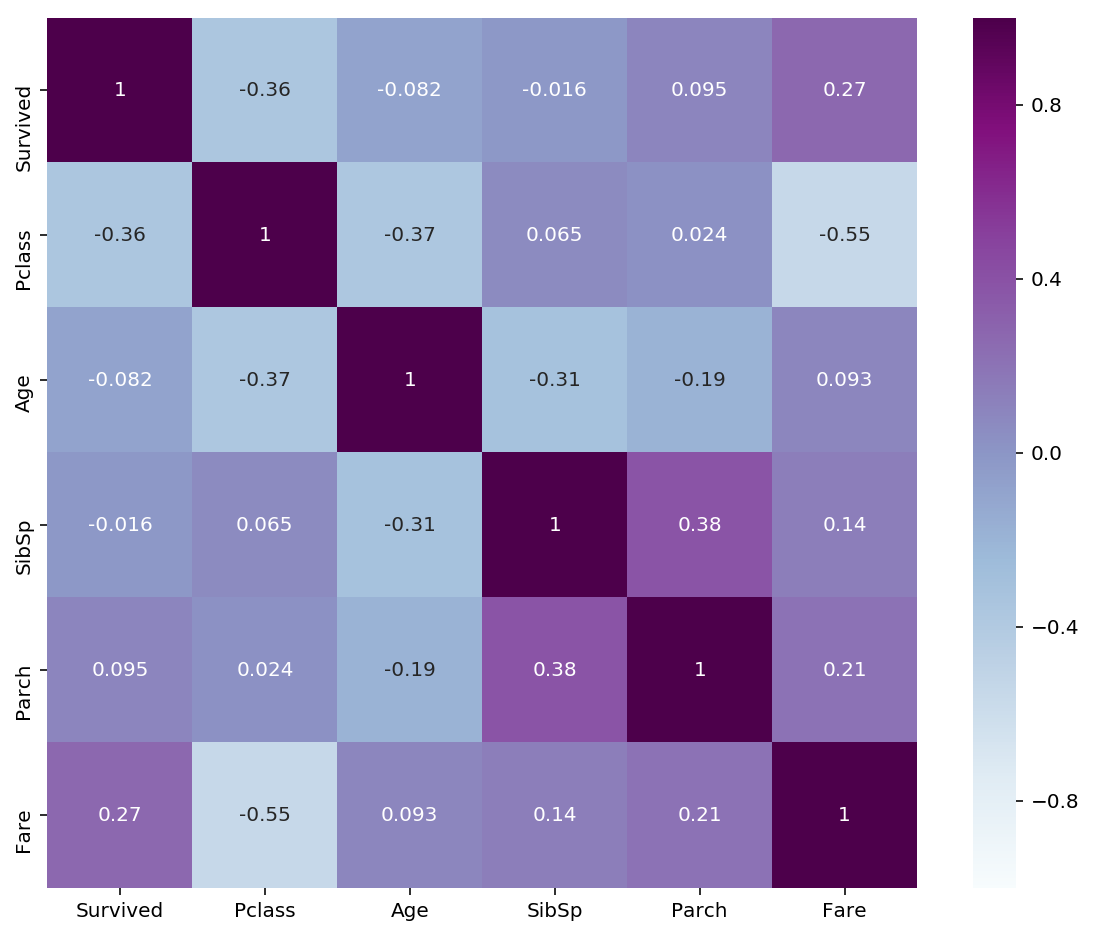

In [139]:
plt.figure(figsize=(10, 8))
sns.heatmap(titanic.corr(), annot=True, square=True, vmin=-1, vmax=1, cmap="BuPu")

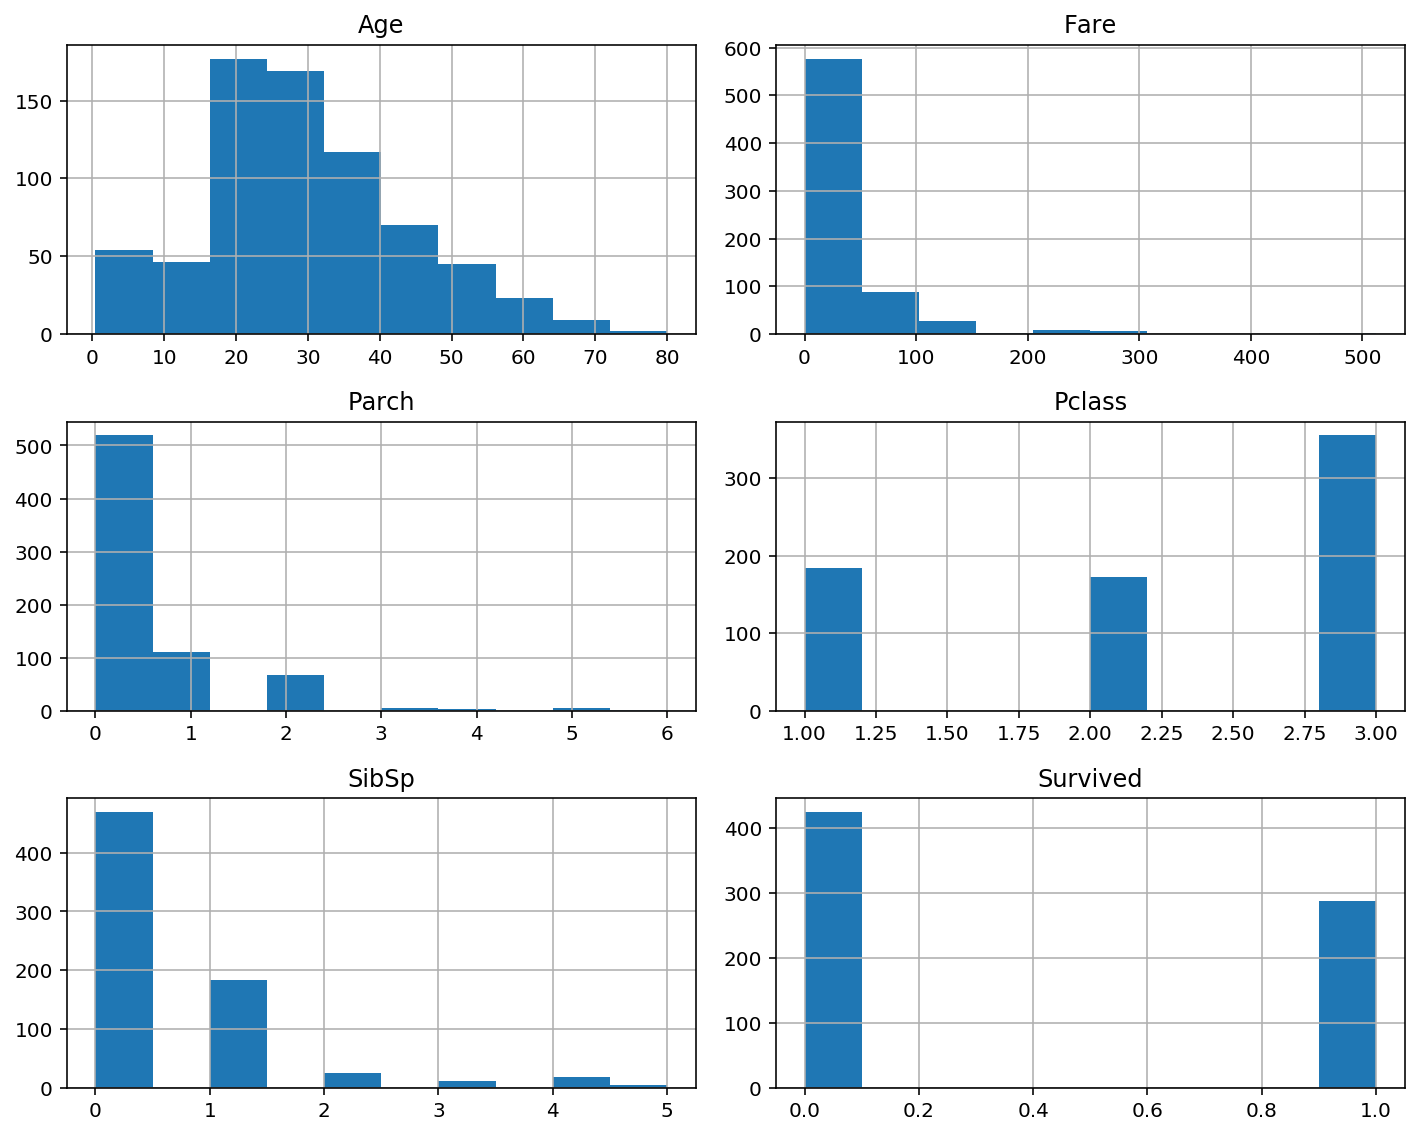

In [140]:
titanic.hist(figsize=(10, 8))
plt.tight_layout()

In [141]:
df = titanic.copy()

ss = StandardScaler()
scale_features = ['Age', 'Fare', 'Parch', 'SibSp', 'Pclass']
df[scale_features] = ss.fit_transform(df[scale_features])

categorical_features = ['Embarked', 'Sex']
df_cat = pd.get_dummies(df[categorical_features])
df = df.drop(categorical_features, axis=1)
df = pd.concat([df, df_cat], axis=1)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,0,0.91,-0.53,0.52,-0.51,-0.52,0,0,1,0,1
1,1,-1.48,0.58,0.52,-0.51,0.69,1,0,0,1,0
2,1,0.91,-0.25,-0.55,-0.51,-0.50,0,0,1,1,0
3,1,-1.48,0.37,0.52,-0.51,0.35,0,0,1,1,0
4,0,0.91,0.37,-0.55,-0.51,-0.50,0,0,1,0,1


In [142]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
count,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00,712.00
mean,0.40,-0.00,0.00,0.00,-0.00,-0.00,0.18,0.04,0.78,0.36,0.64
std,0.49,1.00,1.00,1.00,1.00,1.00,0.39,0.19,0.42,0.48,0.48
min,0.00,-1.48,-2.02,-0.55,-0.51,-0.65,0.00,0.00,0.00,0.00,0.00
25%,0.00,-1.48,-0.67,-0.55,-0.51,-0.50,0.00,0.00,1.00,0.00,0.00
50%,0.00,-0.29,-0.11,-0.55,-0.51,-0.36,0.00,0.00,1.00,0.00,1.00
75%,1.00,0.91,0.58,0.52,0.66,-0.03,0.00,0.00,1.00,1.00,1.00
max,1.00,0.91,3.48,4.82,6.52,9.03,1.00,1.00,1.00,1.00,1.00


In [143]:
X = df.drop('Survived', axis=1).values
y = df['Survived'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(534, 10) (534,) (178, 10) (178,)


In [144]:
print(X_train.shape[0])

534


## Logistic Regression Model

<Figure size 576x432 with 0 Axes>

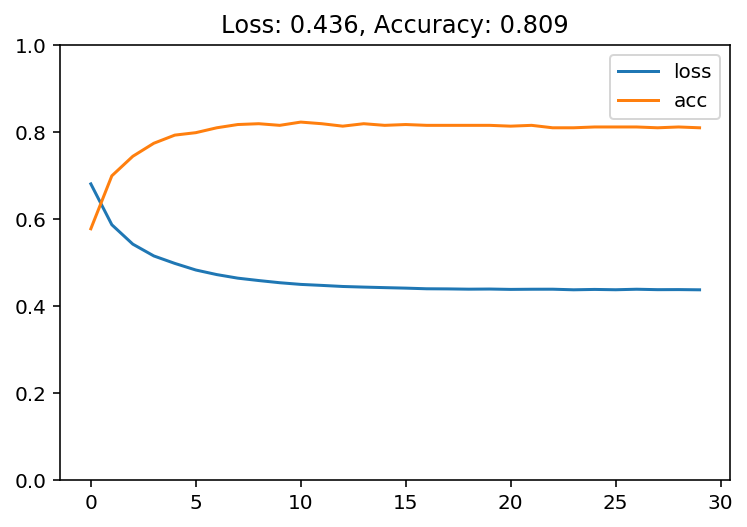

In [145]:
lr_model = Sequential()
lr_model.add(Dense(1, input_shape=(X_train.shape[1],), activation='sigmoid'))

lr_model.compile(Adam(lr=0.01), loss='binary_crossentropy', metrics=['accuracy'])

lr_history = lr_model.fit(X_train, y_train, verbose=0, epochs=30)
plot_loss_accuracy(lr_history)

             precision    recall  f1-score   support

          0       0.79      0.84      0.81       104
          1       0.75      0.69      0.72        74

avg / total       0.77      0.78      0.77       178



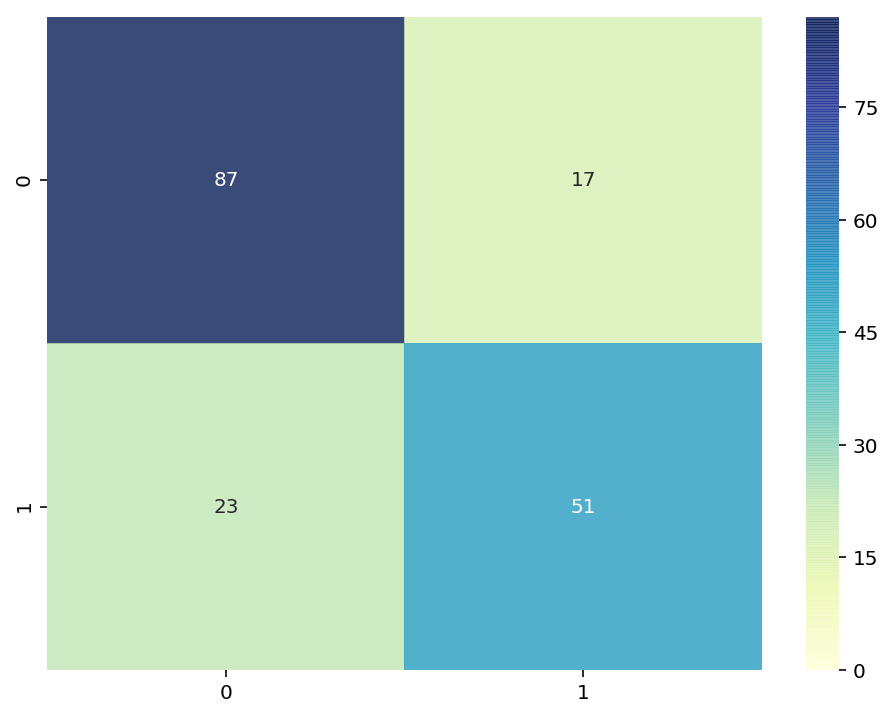

In [146]:
y_pred = lr_model.predict_classes(X_test, verbose=0)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(lr_model, X_test, y_test)

In [147]:
def get_model():
    lr_model = Sequential()
    lr_model.add(Dense(1, input_shape=(X_train.shape[1],), activation='sigmoid'))
    lr_model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])
    return lr_model

new_X, new_y = shuffle(X, y, random_state=0)
model = KerasClassifier(build_fn=get_model, epochs=5, verbose=0)
scores = cross_val_score(model, new_X, new_y, cv=5)
print(scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std()*2))

[0.65734266 0.78321678 0.80985915 0.76056338 0.78169014]
Accuracy: 75.85% (+/- 10.59%)


## Deep Model

<Figure size 576x432 with 0 Axes>

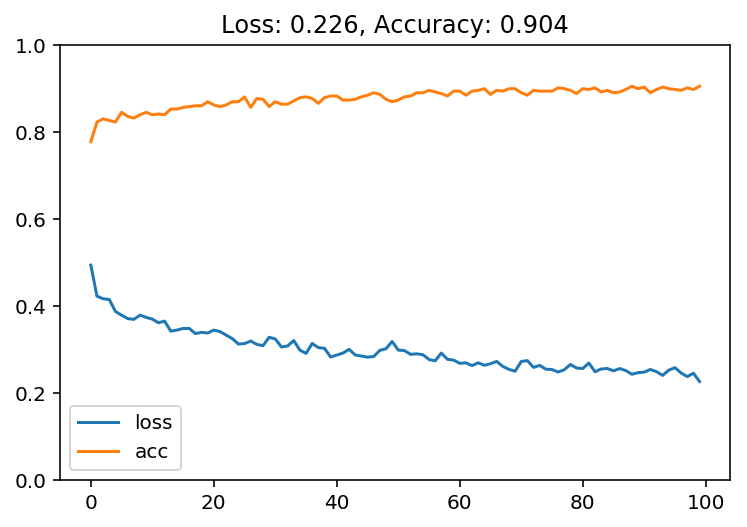

In [148]:
deep_model = Sequential()
deep_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
deep_model.add(Dense(16, activation='relu'))
deep_model.add(Dense(1, activation='sigmoid'))

deep_model.compile(Adam(lr=0.02), 'binary_crossentropy', metrics=['accuracy'])

deep_history = deep_model.fit(X_train, y_train, verbose=0, epochs=100)
plot_loss_accuracy(deep_history)

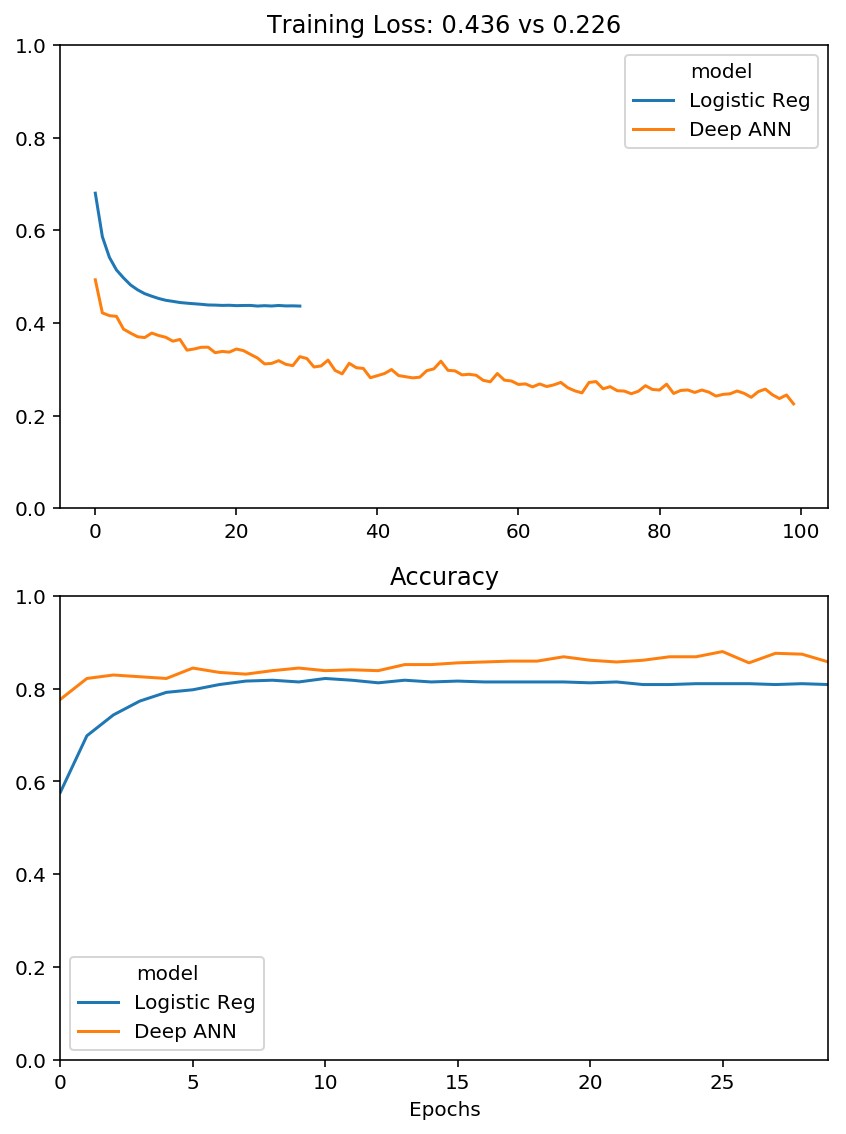

In [149]:
plot_compare_histories([lr_history, deep_history], ['Logistic Reg', 'Deep ANN'])

             precision    recall  f1-score   support

          0       0.78      0.88      0.82       104
          1       0.79      0.65      0.71        74

avg / total       0.78      0.78      0.78       178



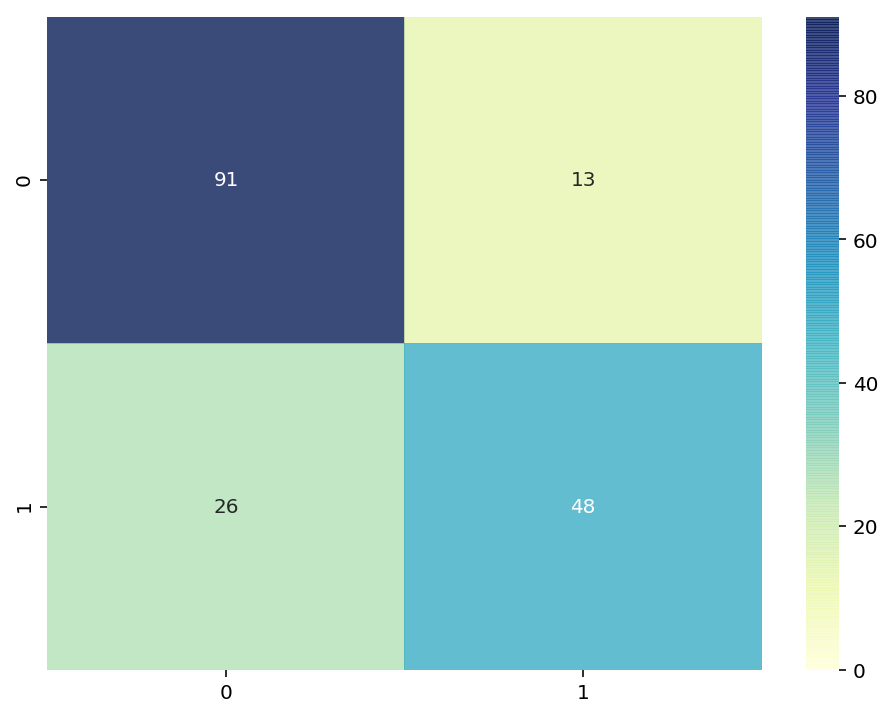

In [150]:
y_pred = deep_model.predict_classes(X_test, verbose=0)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(deep_model, X_test, y_test)

In [151]:
def get_model():
    return deep_model

model = KerasClassifier(build_fn=get_model, epochs=5, verbose=0)
scores = cross_val_score(model, X, y, cv=5)
print(scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std()*2))

[0.83916084 0.81818182 0.86619718 0.82394366 0.86619718]
Accuracy: 84.27% (+/- 4.07%)


## Deep Model Visualization

<Figure size 576x432 with 0 Axes>

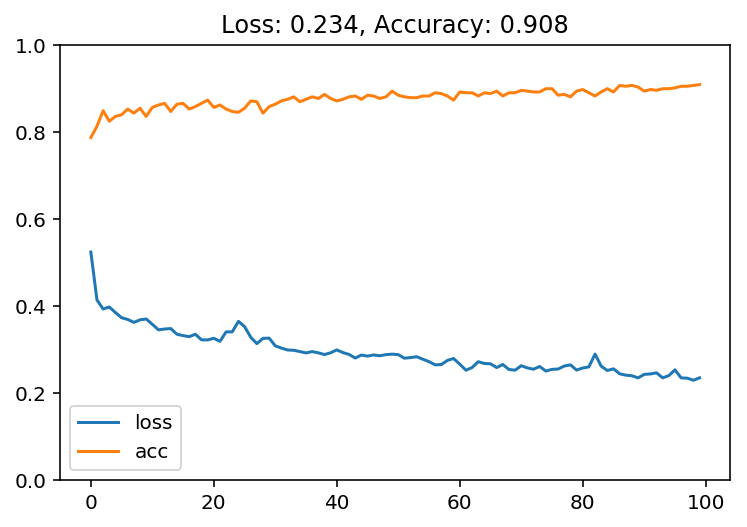

In [152]:
deep_model_vis = Sequential()
deep_model_vis.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
deep_model_vis.add(Dense(16, activation='relu'))
deep_model_vis.add(Dense(2, activation='relu'))
deep_model_vis.add(Dense(1, activation='sigmoid'))

deep_model_vis.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

history = deep_model_vis.fit(X_train, y_train, verbose=0, epochs=100)
plot_loss_accuracy(history)

Text(0.5,1,'Test Data Separation')

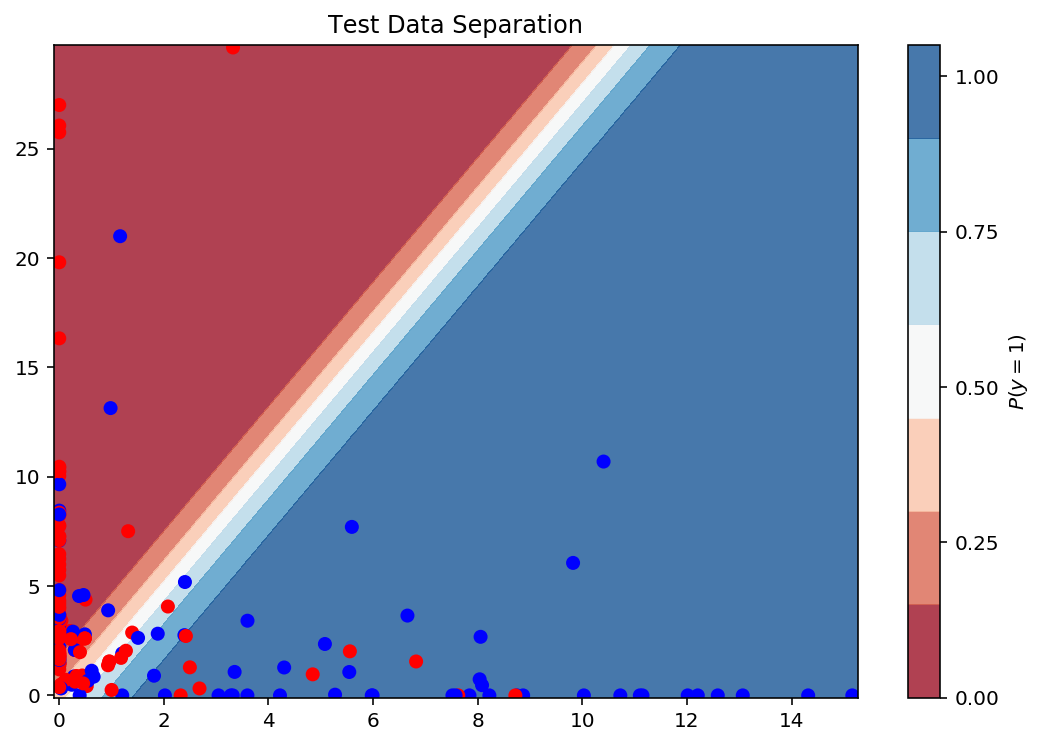

In [153]:
# input to 2-D mapping
inp1 = deep_model_vis.layers[0].input
out1 = deep_model_vis.layers[2].output
func1 = K.function([inp1], [out1])

# 2-D to score prediction
inp2 = deep_model_vis.layers[3].input
out2 = deep_model_vis.layers[3].output
func2 = K.function([inp2], [out2])

features = func1([X_test])[0]
plot_decision_boundary(lambda x: func2([x])[0], features, y_test)
plt.title('Test Data Separation')

             precision    recall  f1-score   support

          0       0.76      0.83      0.79       104
          1       0.72      0.64      0.68        74

avg / total       0.75      0.75      0.74       178



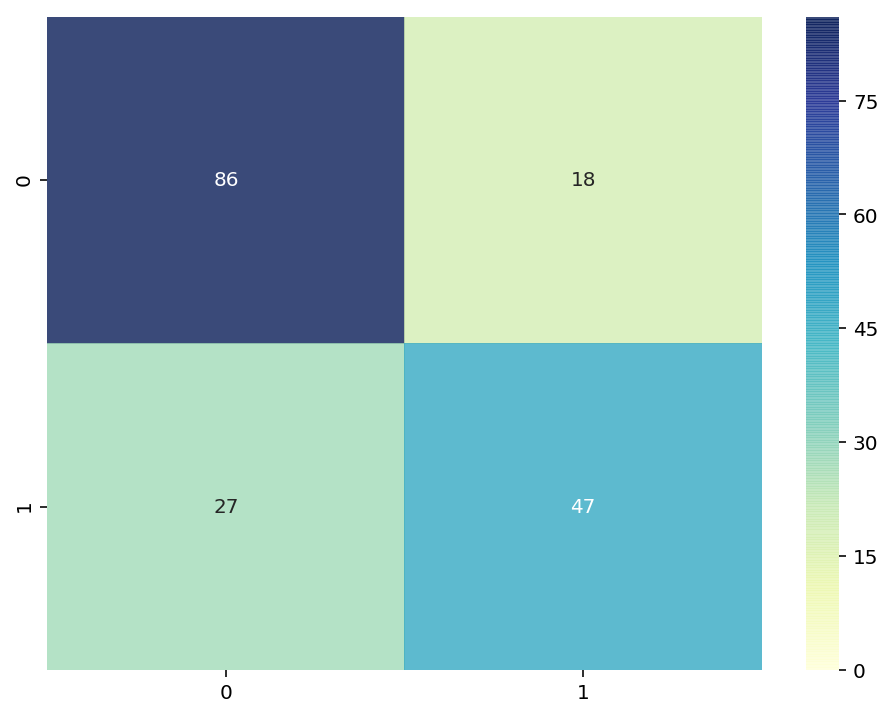

In [154]:
y_pred = deep_model_vis.predict_classes(X_test, verbose=0)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(deep_model_vis, X_test, y_test)

## Trial

Text(0.5,1,'Test Data Separation')

<Figure size 576x432 with 0 Axes>

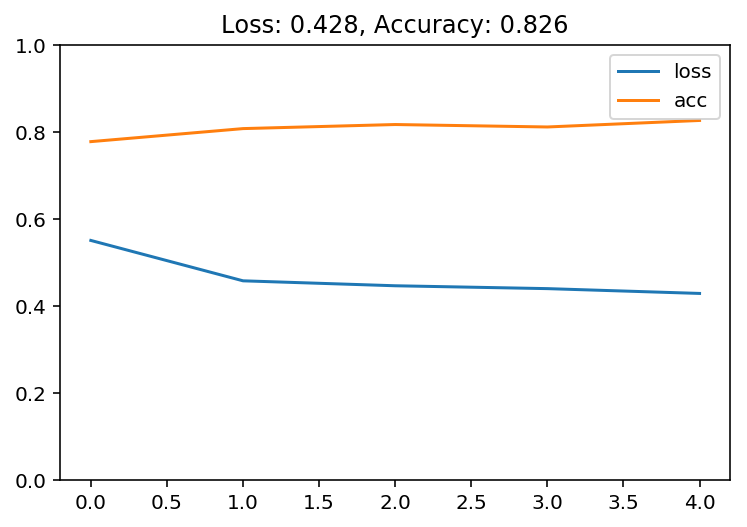

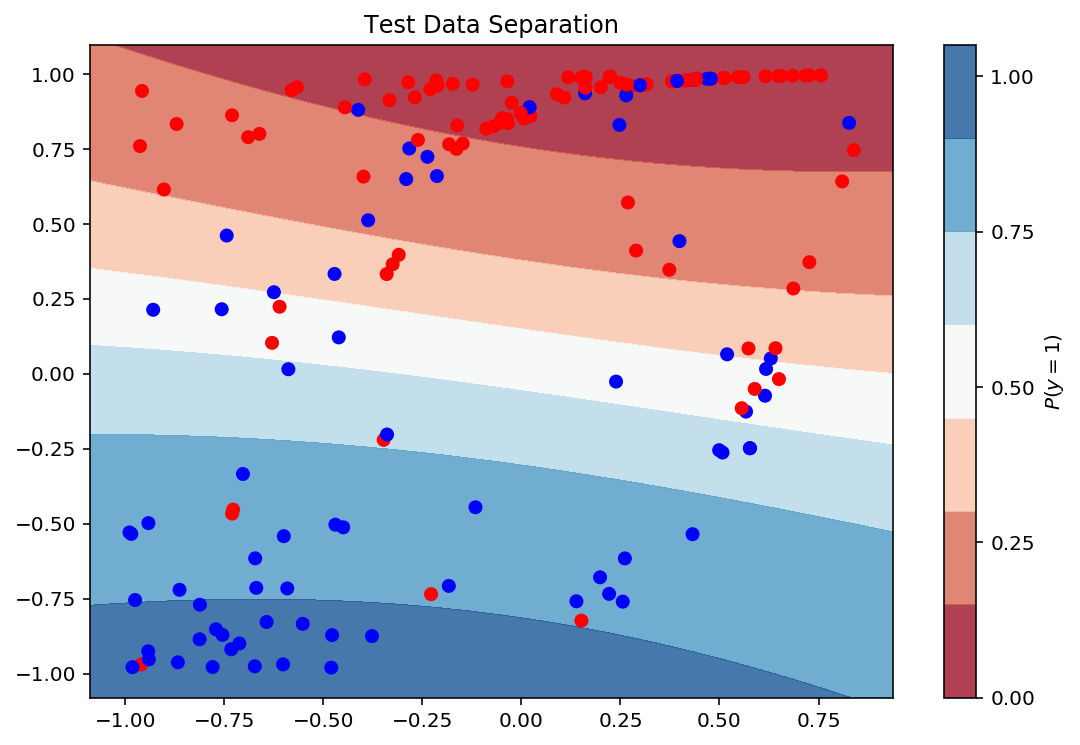

In [155]:
deep_model_vis = Sequential()
deep_model_vis.add(Dense(64, input_shape=(X_train.shape[1],), activation='tanh'))
deep_model_vis.add(Dense(2, activation='tanh'))
deep_model_vis.add(Dense(8, activation='tanh'))
deep_model_vis.add(Dense(16, activation='tanh'))
deep_model_vis.add(Dense(1, activation='sigmoid'))

deep_model_vis.compile(Adam(lr=0.005), 'binary_crossentropy', metrics=['accuracy'])

history = deep_model_vis.fit(X_train, y_train, verbose=0, epochs=5)
plot_loss_accuracy(history)

# input to 2-D mapping
inp1 = deep_model_vis.layers[0].input
out1 = deep_model_vis.layers[1].output
func1 = K.function([inp1], [out1])

# 2-D to score prediction
inp2 = deep_model_vis.layers[2].input
out2 = deep_model_vis.layers[-1].output
func2 = K.function([inp2], [out2])

features = func1([X_test])[0]
plot_decision_boundary(lambda x: func2([x])[0], features, y_test)
plt.title('Test Data Separation')

## Even deeper model

In [ ]:
deeper_model = Sequential()
deeper_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='tanh'))
deeper_model.add(Dense(64, activation='tanh'))
deeper_model.add(Dense(1, activation='sigmoid'))

deeper_model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

deeper_history = deeper_model.fit(X_train, y_train, verbose=1, epochs=10)
plot_loss_accuracy(deeper_history)

In [ ]:
y_pred = deep_model.predict_classes(X_test, verbose=0)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(deep_model, X_test, y_test)

# Case Study - MultiClass Classification

We will be using the well known Iris dataset.

## Data Visualization & Preparation

In [132]:
df = pd.read_csv('../data/iris.csv')
df.sample(n=5)

,sepal_length,sepal_width,petal_length,petal_width,label
38,4.40,3.00,1.30,0.20,setosa
36,5.50,3.50,1.30,0.20,setosa
1,4.90,3.00,1.40,0.20,setosa
98,5.10,2.50,3.00,1.10,versicolor
128,6.40,2.80,5.60,2.10,virginica


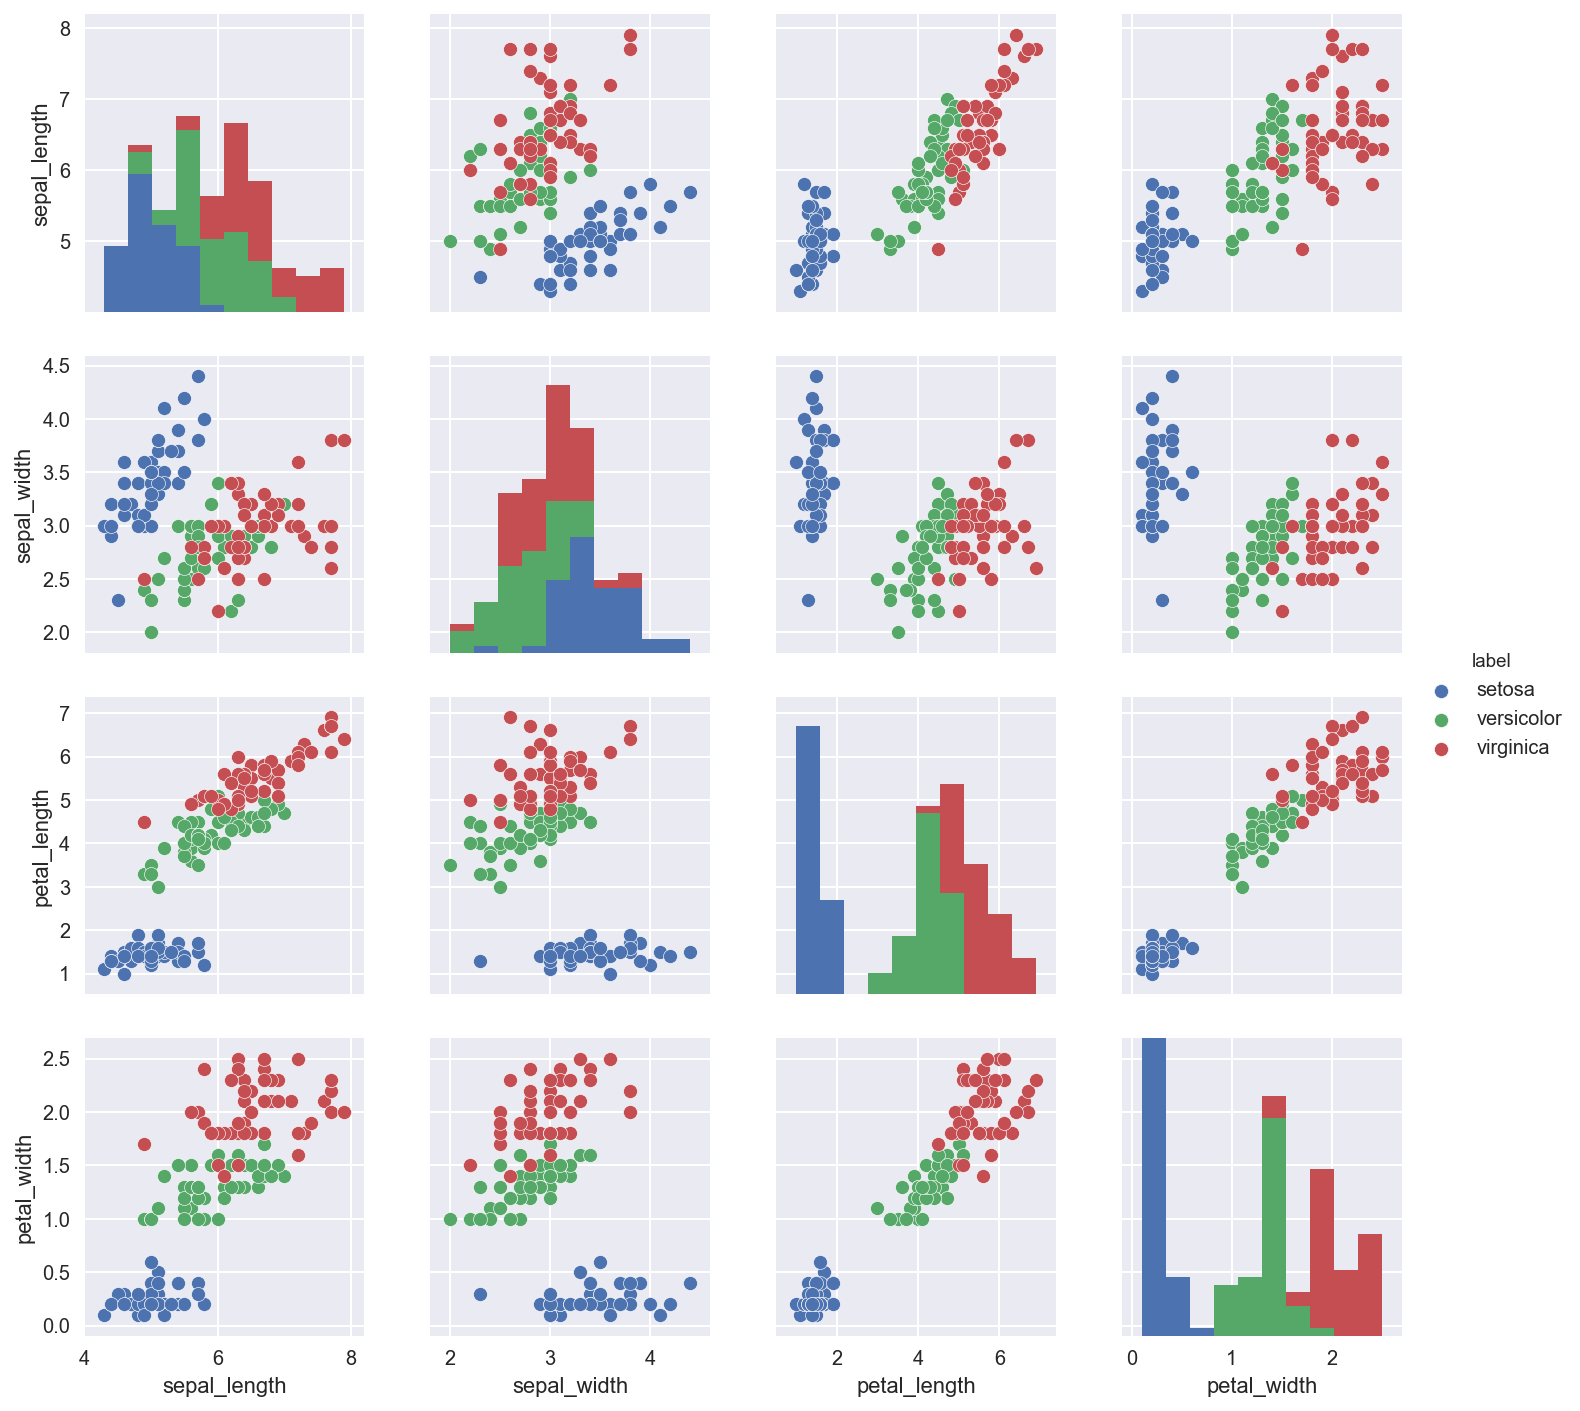

In [123]:
sns.pairplot(df, hue='label')

In [139]:
X = df.values[:, :-1]
ss = StandardScaler()
X = ss.fit_transform(X)
y = pd.get_dummies(df['label']).values
print(X.shape, y.shape)

(150, 4) (150, 3)


In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)

(120, 4) (120, 3)


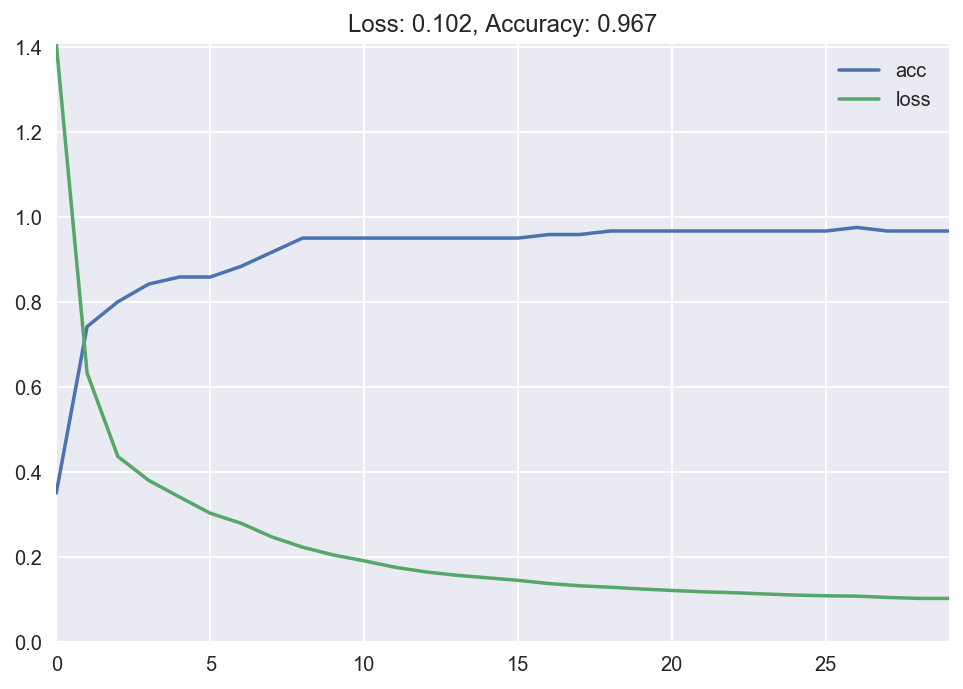

In [165]:
sr_model = Sequential()
sr_model.add(Dense(3, input_shape=(X.shape[1],), activation='softmax'))

sr_model.compile(Adam(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

history = sr_model.fit(X_train, y_train, epochs=30, verbose=0)
plot_loss_accuracy(history)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        11
          1       1.00      1.00      1.00         7
          2       1.00      1.00      1.00        12

avg / total       1.00      1.00      1.00        30



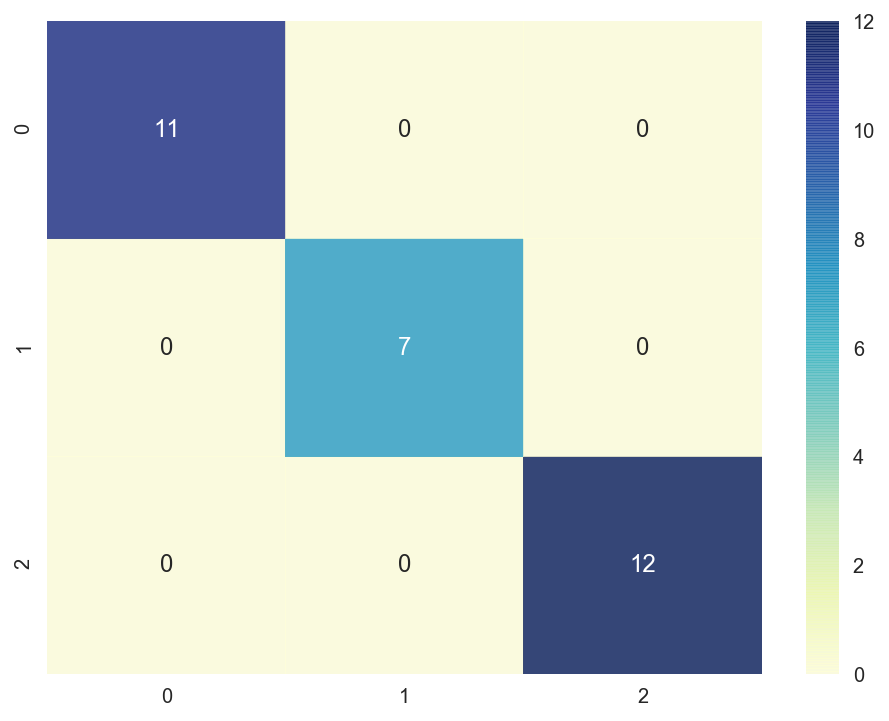

In [164]:
y_pred_class = model.predict_classes(X_test, verbose=0)
y_test_class = np.argmax(y_test, axis=1)
print(classification_report(y_test_class, y_pred_class))
plot_confusion_matrix(model, X_test, y_test_class)

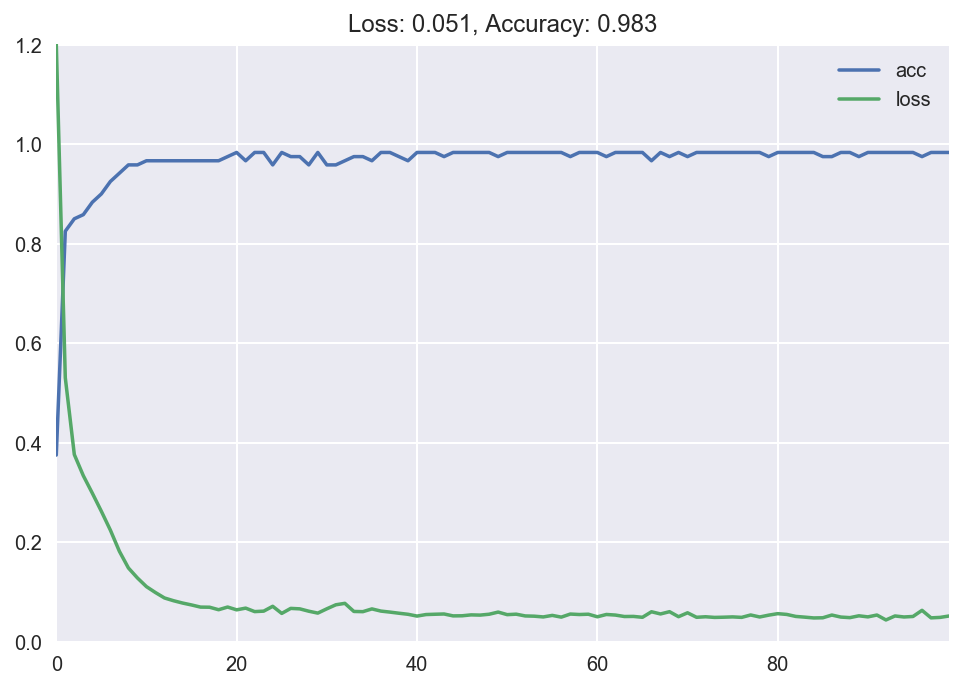

In [167]:
deep_model = Sequential()
deep_model.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
deep_model.add(Dense(16, input_shape=(X.shape[1],), activation='relu'))
deep_model.add(Dense(3, activation='softmax'))

deep_model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

history = deep_model.fit(X_train, y_train, epochs=100, verbose=0)
plot_loss_accuracy(history)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        11
          1       1.00      1.00      1.00         7
          2       1.00      1.00      1.00        12

avg / total       1.00      1.00      1.00        30



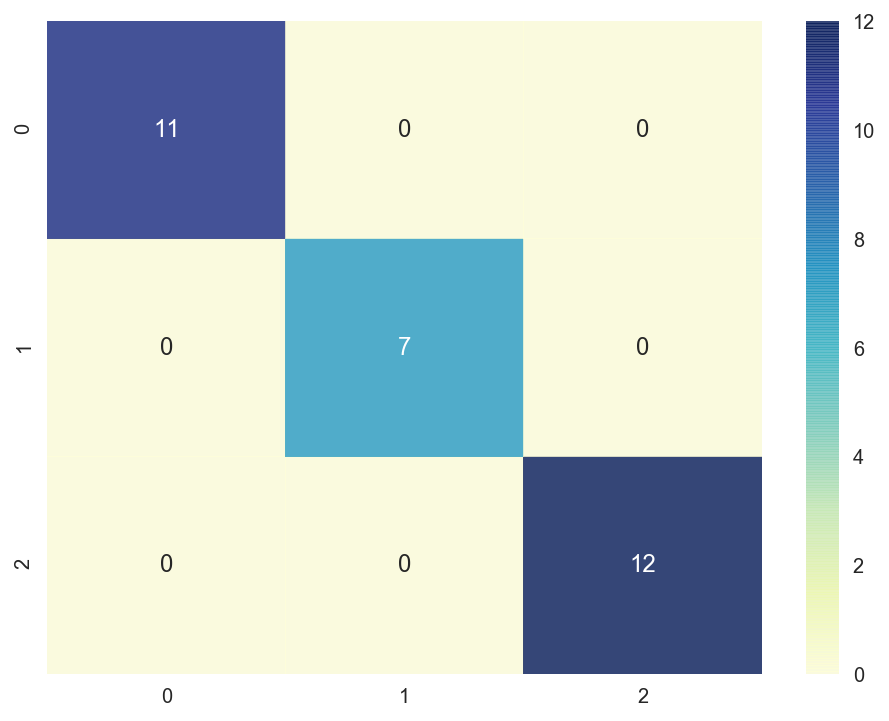

In [163]:
y_pred_class = model.predict_classes(X_test, verbose=0)
y_test_class = np.argmax(y_test, axis=1)
print(classification_report(y_test_class, y_pred_class))
plot_confusion_matrix(model, X_test, y_test_class)

In [168]:
def get_linear_model():
    model = Sequential()
    model.add(Dense(3, input_shape=(X.shape[1],), activation='softmax'))
    model.compile(Adam(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def get_deep_model():
    model = Sequential()
    model.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
    model.add(Dense(16, input_shape=(X.shape[1],), activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cv = StratifiedKFold(n_splits=5, random_state=0)

lin_model = KerasClassifier(build_fn=get_linear_model, epochs=50, verbose=0)
lin_scores = cross_val_score(lin_model, X, df['label'].values, cv=cv)
print(lin_scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*lin_scores.mean(), 100*lin_scores.std()*2))

deep_model = KerasClassifier(build_fn=get_deep_model, epochs=50, verbose=0)
deep_scores = cross_val_score(deep_model, X, df['label'].values, cv=cv)
print(deep_scores)
print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*deep_scores.mean(), 100*deep_scores.std()*2))

[ 1.          1.          0.93333334  0.89999998  1.        ]
Accuracy: 96.67% (+/- 8.43%)
[ 0.96666664  0.96666664  0.96666664  0.93333334  0.96666664]
Accuracy: 96.00% (+/- 2.67%)


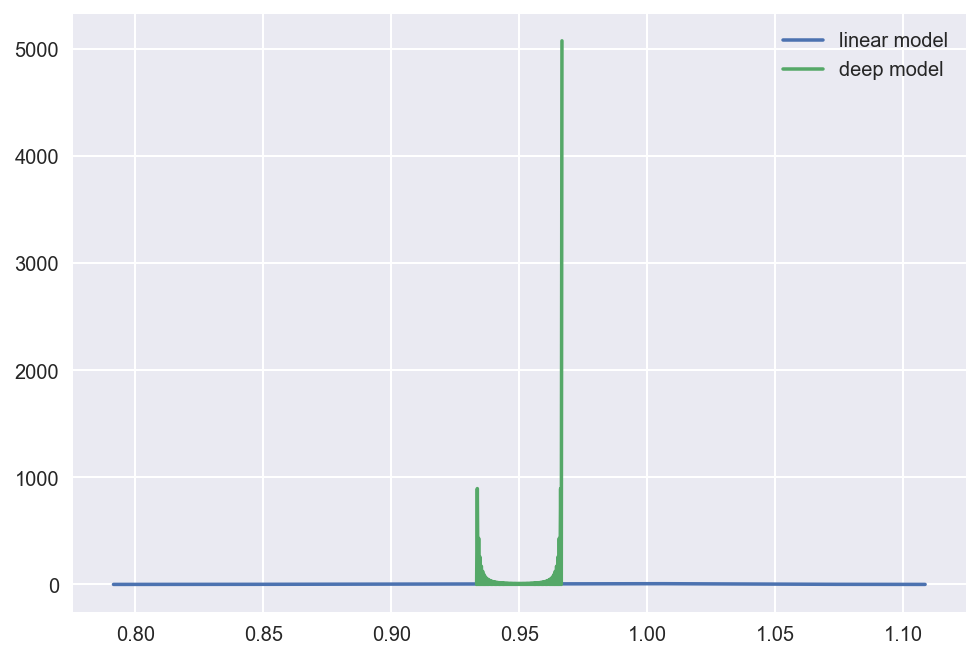

In [169]:
sns.distplot(lin_scores, hist=False, label='linear model')
sns.distplot(deep_scores, hist=False, label='deep model')

# Case Study - Regression

We will be using the house sales dataset from King County, WA on Kaggle: https://www.kaggle.com/harlfoxem/housesalesprediction

The data has around 21,000 rows with 20 features. The value we're tring to predict is a floating point number labeld as "price".

## Data Visualization & Preparation

In [170]:
rawdf = pd.read_csv('../data/kc_house_data.csv')
rawdf.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,"221,900.00",3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,20141209T000000,"538,000.00",3,2.25,2570,7242,2.00,0,0,3,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,20150225T000000,"180,000.00",2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,2487200875,20141209T000000,"604,000.00",4,3.00,1960,5000,1.00,0,0,5,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,20150218T000000,"510,000.00",3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503


In [171]:
rawdf.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,"21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00"
mean,"4,580,301,520.86","540,088.14",3.37,2.11,"2,079.90","15,106.97",1.49,0.01,0.23,3.41,7.66,"1,788.39",291.51,"1,971.01",84.40,"98,077.94",47.56,-122.21,"1,986.55","12,768.46"
std,"2,876,565,571.31","367,127.20",0.93,0.77,918.44,"41,420.51",0.54,0.09,0.77,0.65,1.18,828.09,442.58,29.37,401.68,53.51,0.14,0.14,685.39,"27,304.18"
min,"1,000,102.00","75,000.00",0.00,0.00,290.00,520.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,"1,900.00",0.00,"98,001.00",47.16,-122.52,399.00,651.00
25%,"2,123,049,194.00","321,950.00",3.00,1.75,"1,427.00","5,040.00",1.00,0.00,0.00,3.00,7.00,"1,190.00",0.00,"1,951.00",0.00,"98,033.00",47.47,-122.33,"1,490.00","5,100.00"
50%,"3,904,930,410.00","450,000.00",3.00,2.25,"1,910.00","7,618.00",1.50,0.00,0.00,3.00,7.00,"1,560.00",0.00,"1,975.00",0.00,"98,065.00",47.57,-122.23,"1,840.00","7,620.00"
75%,"7,308,900,445.00","645,000.00",4.00,2.50,"2,550.00","10,688.00",2.00,0.00,0.00,4.00,8.00,"2,210.00",560.00,"1,997.00",0.00,"98,118.00",47.68,-122.12,"2,360.00","10,083.00"
max,"9,900,000,190.00","7,700,000.00",33.00,8.00,"13,540.00","1,651,359.00",3.50,1.00,4.00,5.00,13.00,"9,410.00","4,820.00","2,015.00","2,015.00","98,199.00",47.78,-121.31,"6,210.00","871,200.00"


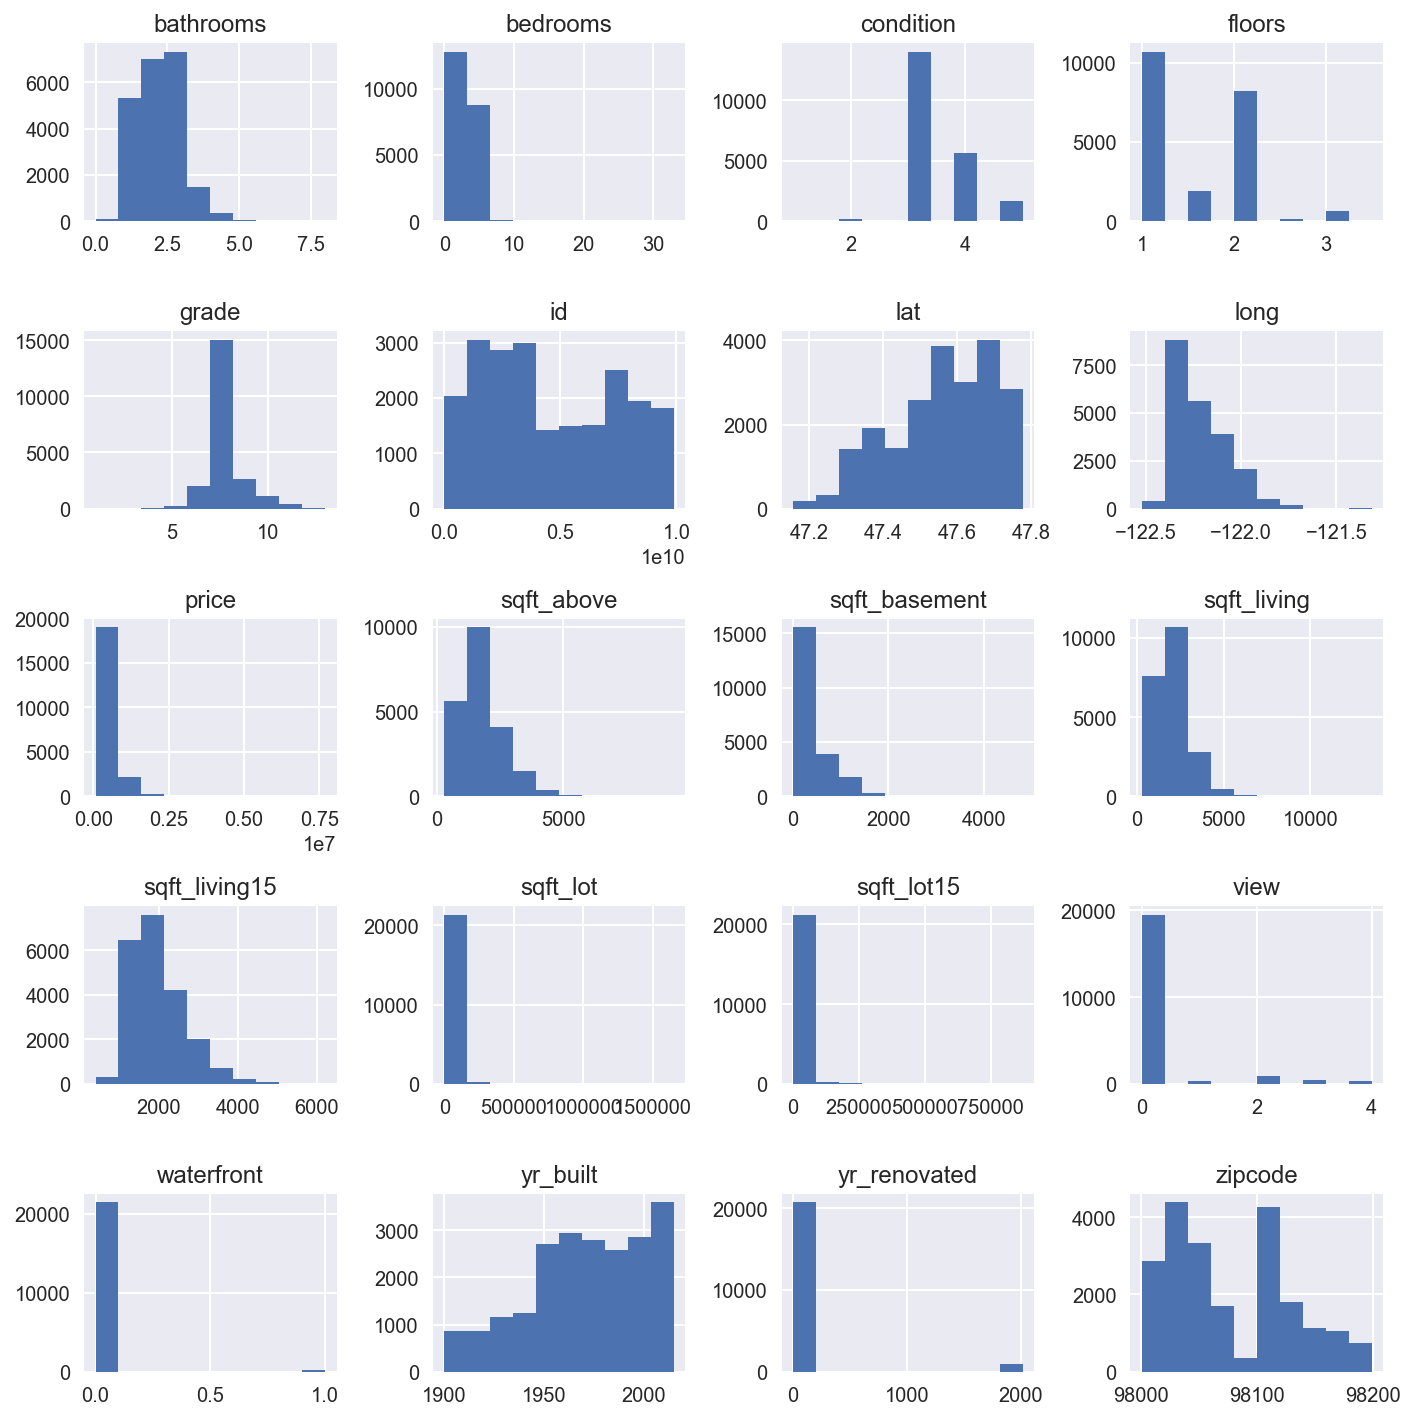

In [172]:
rawdf.hist(figsize=(10, 10))
plt.tight_layout()

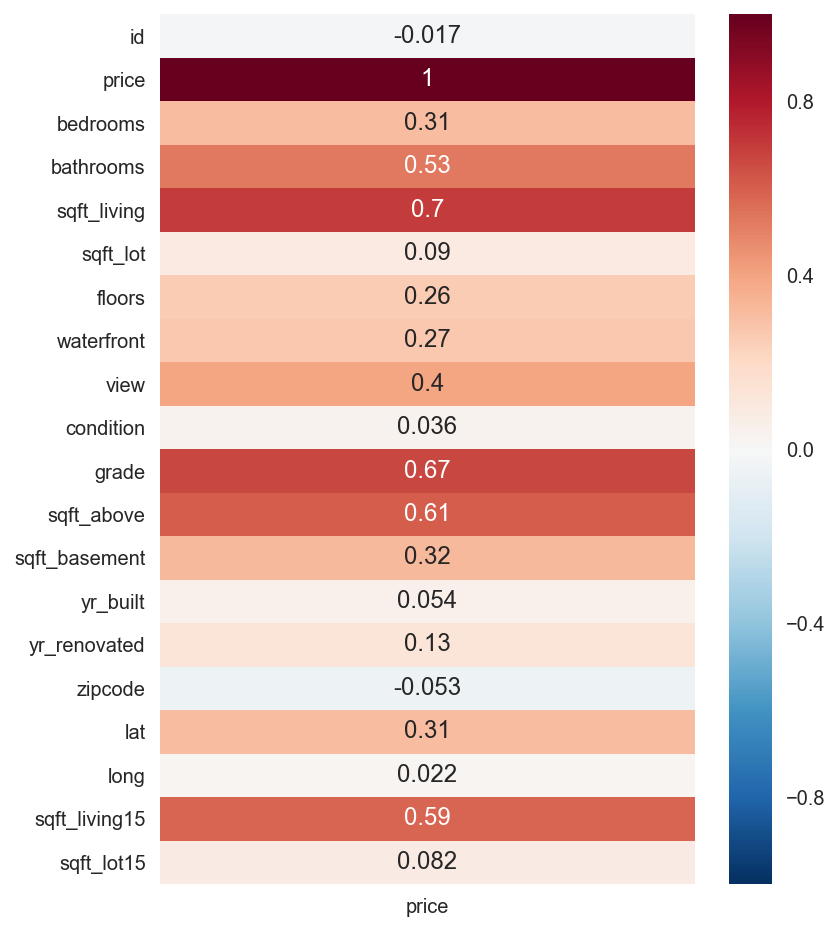

In [177]:
plt.figure(figsize=(6, 8))
sns.heatmap(rawdf.corr()[['price']], annot=True, vmin=-1, vmax=1)

In [197]:
df = rawdf.copy()

# features that need to be scaled
ss = StandardScaler()
scale_features = ['bathrooms', 'bedrooms', 'grade', 'sqft_above', 
                  'sqft_basement', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15']
df[scale_features] = ss.fit_transform(df[scale_features])

# bucketized features
bucketized_features = ['yr_built', 'yr_renovated', 'lat', 'long']

bins = range(1890, 2021, 10)
df['yr_built'] = pd.cut(df.yr_built, bins, labels=bins[:-1])

bins = range(1930, 2021, 10)
bins = [-10] + bins
df['yr_renovated'] = pd.cut(df.yr_renovated, bins, labels=bins[:-1])

bins = np.arange(47.00, 47.90, 0.05)
df['lat'] = pd.cut(df.lat, bins, labels=bins[:-1])

bins = np.arange(-122.60, -121.10, 0.05)
df['long'] = pd.cut(df.long, bins, labels=bins[:-1])

# categorical features
df['date'] = [datetime.strptime(x, '%Y%m%dT000000').strftime('%Y-%m') for x in rawdf['date'].values]
df['zipcode'] = df['zipcode'].astype('string')
categorical_features = ['zipcode', 'date']
categorical_features.extend(bucketized_features)
df_cat = pd.get_dummies(df[categorical_features])
df = df.drop(categorical_features, axis=1)
df = pd.concat([df, df_cat], axis=1)

# drop features
drop_features = ['id']
df = df.drop(drop_features, axis=1)

df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,date_2014-05,date_2014-06,date_2014-07,date_2014-08,date_2014-09,date_2014-10,date_2014-11,date_2014-12,date_2015-01,date_2015-02,date_2015-03,date_2015-04,date_2015-05,yr_built_1890,yr_built_1900,yr_built_1910,yr_built_1920,yr_built_1930,yr_built_1940,yr_built_1950,yr_built_1960,yr_built_1970,yr_built_1980,yr_built_1990,yr_built_2000,yr_built_2010,yr_renovated_-10,yr_renovated_1930,yr_renovated_1940,yr_renovated_1950,yr_renovated_1960,yr_renovated_1970,yr_renovated_1980,yr_renovated_1990,yr_renovated_2000,yr_renovated_2010,lat_47.0,lat_47.05,lat_47.1,lat_47.15,lat_47.2,lat_47.25,lat_47.3,lat_47.35,lat_47.4,lat_47.45,lat_47.5,lat_47.55,lat_47.6,lat_47.65,lat_47.7,lat_47.75,lat_47.8,long_-122.6,long_-122.55,long_-122.5,long_-122.45,long_-122.4,long_-122.35,long_-122.3,long_-122.25,long_-122.2,long_-122.15,long_-122.1,long_-122.05,long_-122.0,long_-121.95,long_-121.9,long_-121.85,long_-121.8,long_-121.75,long_-121.7,long_-121.65,long_-121.6,long_-121.55,long_-121.5,long_-121.45,long_-121.4,long_-121.35,long_-121.3,long_-121.25,long_-121.2
0,"221,900.00",-0.40,-1.45,-0.98,-0.23,1.00,0,0,3,-0.56,-0.73,-0.66,-0.94,-0.26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"538,000.00",-0.40,0.18,0.53,-0.19,2.00,0,0,3,-0.56,0.46,0.25,-0.43,-0.19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"180,000.00",-1.47,-1.45,-1.43,-0.12,1.00,0,0,3,-1.41,-1.23,-0.66,1.07,-0.17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"604,000.00",0.68,1.15,-0.13,-0.24,1.00,0,0,5,-0.56,-0.89,1.40,-0.91,-0.28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"510,000.00",-0.40,-0.15,-0.44,-0.17,1.00,0,0,3,0.29,-0.13,-0.66,-0.27,-0.19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

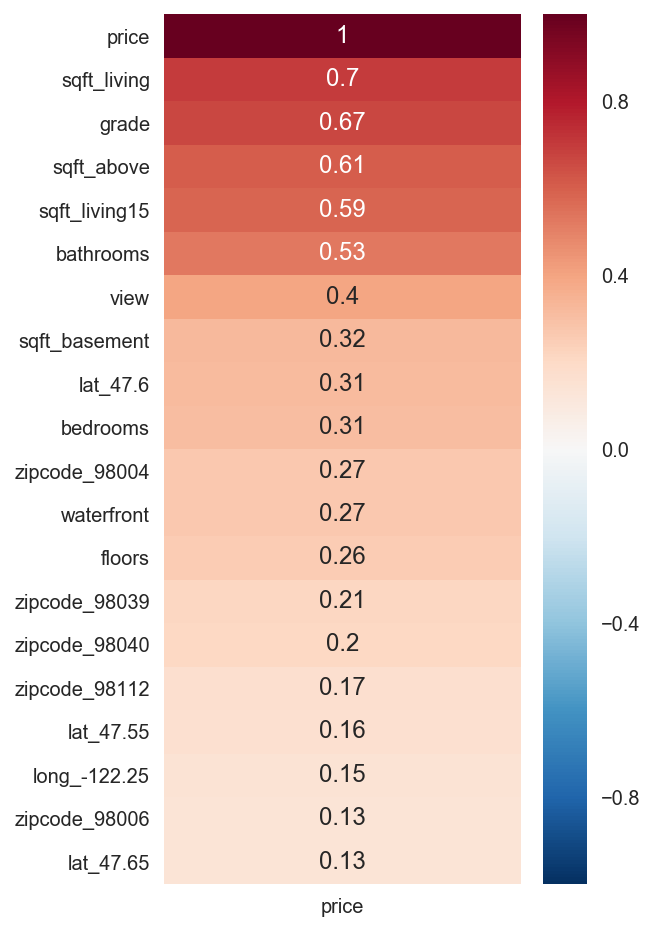

In [212]:
plt.figure(figsize=(4, 8))
tempdf = df.corr()[['price']].sort_values('price', ascending=False).iloc[:20, :]
sns.heatmap(tempdf, annot=True, vmin=-1, vmax=1)

In [199]:
X = df.drop(['price'], axis=1).values
y = df['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# outlier sanitization of the training set
factor = 5
y_train[np.abs(y_train - y_train.mean()) > (factor * y_train.std())] = y_train.mean() + factor*y_train.std()

# scale the price
ss_price = StandardScaler()
y_train = ss_price.fit_transform(y_train)
y_test = ss_price.transform(y_test)

(17290, 165) (17290,) (4323, 165) (4323,)


/Users/ardend/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/ardend/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/ardend/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if yo

## Linear Regression Model

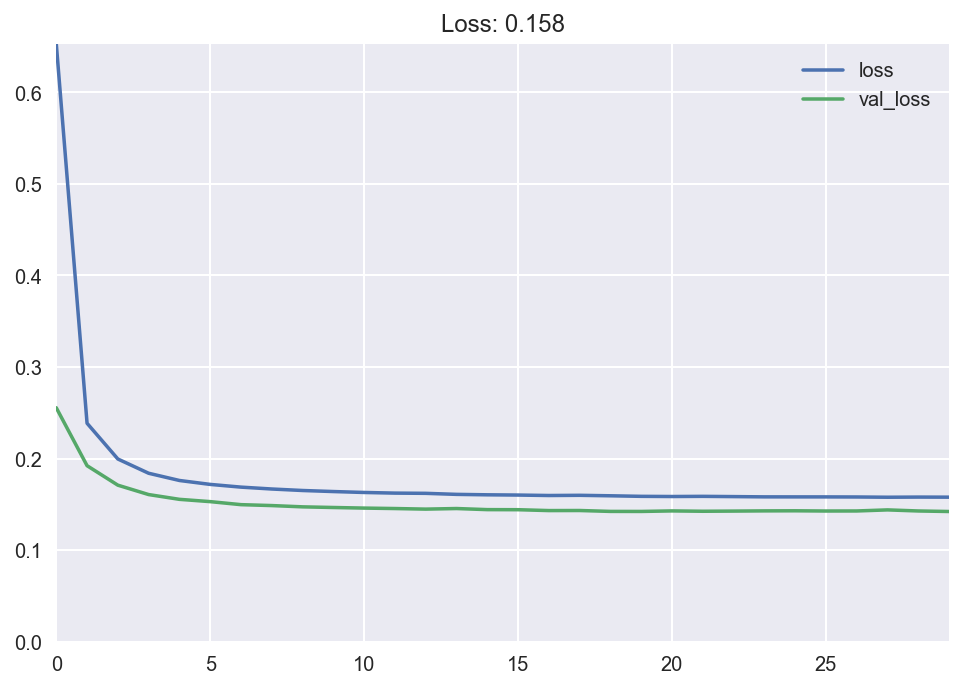

In [232]:
linr_model = Sequential()
linr_model.add(Dense(1, input_shape=(X.shape[1],)))

linr_model.compile('adam', 'mean_squared_error')

linr_history = linr_model.fit(X_train, y_train, epochs=30, verbose=0, validation_split=0.2)
plot_loss(linr_history)

In [240]:
linr_model.evaluate(X_test, y_test, verbose=0)

0.19159423998183683

In [213]:
# weights data frame
linr_wdf = pd.DataFrame(linr_model.get_weights()[0].T, 
                      columns=df.drop(['price'], axis=1).columns).T.sort_values(0, ascending=False)
linr_wdf.columns = ['feature_weight']
linr_wdf.iloc[:20,:]

,feature_weight
zipcode_98039,1.87
waterfront,1.46
zipcode_98004,1.17
zipcode_98112,0.76
zipcode_98040,0.61
zipcode_98109,0.48
zipcode_98105,0.44
zipcode_98119,0.42
zipcode_98102,0.41
lat_47.6,0.39


## Deep Model

The loss is behaving incosistently between runs, this one was good but the previous ones were bad. Needs debugging.

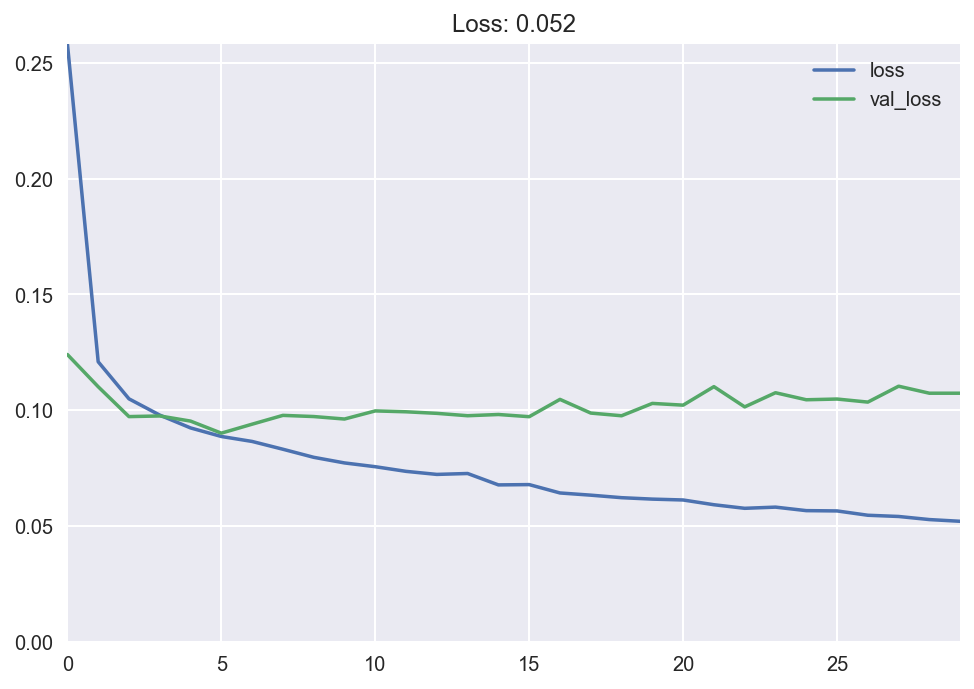

In [234]:
deep_model = Sequential()
deep_model.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
deep_model.add(Dense(16, activation='relu'))
deep_model.add(Dense(8, activation='relu'))
deep_model.add(Dense(1))

deep_model.compile('adam', 'mean_squared_error')

# early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
deep_history = deep_model.fit(X_train, y_train, epochs=30, verbose=0, validation_split=0.2)
#                               callbacks=[early_stop])
plot_loss(deep_history)

Epoch 00007: early stopping


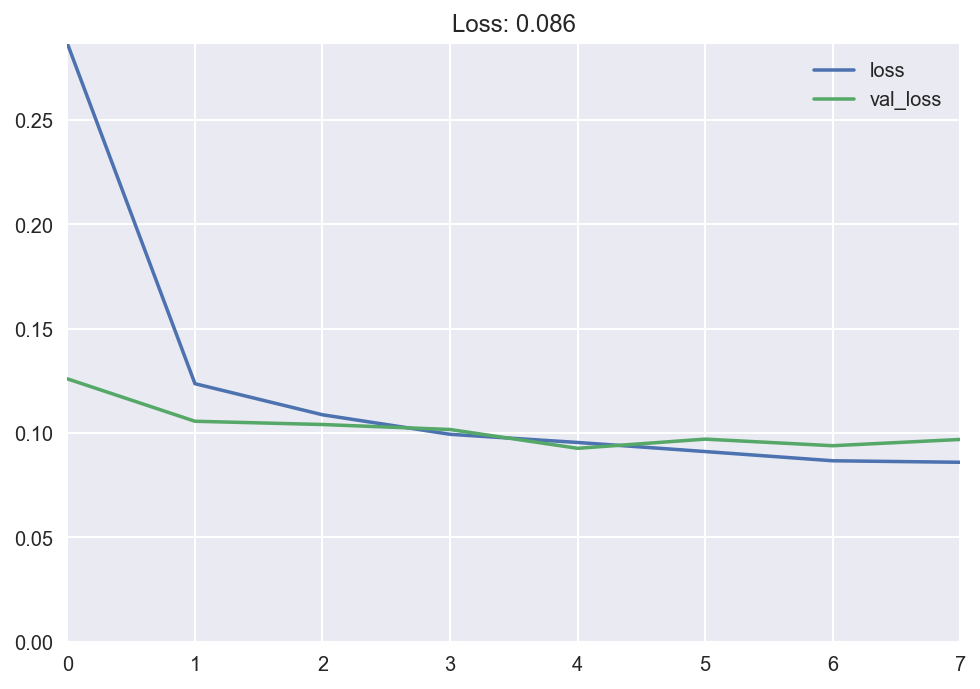

In [238]:
# with early stopping
deep_model = Sequential()
deep_model.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
deep_model.add(Dense(16, activation='relu'))
deep_model.add(Dense(8, activation='relu'))
deep_model.add(Dense(1))

deep_model.compile('adam', 'mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
deep_history = deep_model.fit(X_train, y_train, epochs=30, verbose=0, validation_split=0.2,
                              callbacks=[early_stop])
plot_loss(deep_history)

In [239]:
deep_model.evaluate(X_test, y_test, verbose=0)

0.12847778237468524

In [220]:
# func = K.function([deep_model.layers[0].input], [deep_model.layers[1].output])
# func([X_test[0:10, :]])

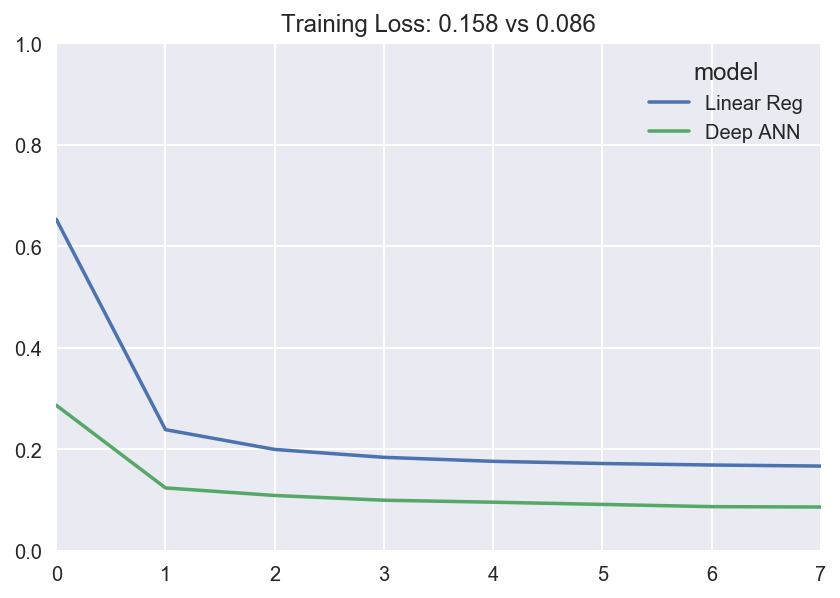

In [262]:
plot_compare_histories([linr_history, deep_history], ['Linear Reg', 'Deep ANN'], plot_accuracy=False)

In [260]:
def output_dollars(num):
    return '$'+str("{:,}".format(int(num)))

print('Average house price:', output_dollars(rawdf['price'].mean()))

real_prices = ss_price.inverse_transform(y_test)

# print('Training set house price:', np.mean(ss_price.inverse_transform(y_train)))

train_prices = ss_price.inverse_transform(y_train)
dumb_prices = np.zeros(real_prices.shape)
dumb_prices.fill(train_prices.mean())
dumb_error = mean_absolute_error(real_prices, dumb_prices)
print('Dumb model error:', output_dollars(dumb_error))

linr_predictions = linr_model.predict(X_test).ravel()
linr_prices = ss_price.inverse_transform(linr_predictions)
linr_error = mean_absolute_error(real_prices, linr_prices)
print('Linear model error:', output_dollars(linr_error))

deep_predictions = deep_model.predict(X_test).ravel()
deep_prices = ss_price.inverse_transform(deep_predictions)
deep_error = mean_absolute_error(real_prices, deep_prices)
print('Deep model error:', output_dollars(deep_error))

tdf = pd.DataFrame([['Naive Model', output_dollars(dumb_error)], 
                    ['Linear Regression', output_dollars(linr_error)], 
                    ['Deep ANN', output_dollars(deep_error)]], 
                   columns=['Model', 'Price Error'])
tdf

Average house price: $540,088
Dumb model error: $229,981
Linear model error: $87,147
Deep model error: $68,074


,Model,Price Error
0,Naive Model,"$229,981"
1,Linear Regression,"$87,147"
2,Deep ANN,"$68,074"


In [255]:
print(r2_score(real_prices, dumb_prices), r2_score(real_prices, linr_prices), r2_score(real_prices, deep_prices))

-0.000699456510588 0.816852442013 0.877186336829


In [41]:
X=range(30)
y=range(30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train)
print(X_test)

[27, 8, 17, 19, 2, 4, 23, 14, 18, 7, 6, 15, 13, 21, 5, 25, 9, 1, 24, 16, 29]
[3, 11, 26, 20, 22, 28, 0, 10, 12]
